# Семинар 2

In [1]:
! apt-get install imagemagick
! mkdir saved_gifs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts imagemagick-6-common
  imagemagick-6.q16 libdjvulibre-text libdjvulibre21 libfftw3-double3 libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10 libwmflite-0.2-7 netpbm
  poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x imagemagick-doc
  autotrace cups-bsd | lpr | lprng enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer
  povray radiance sane-utils texlive-base-bin transfig ufraw-batch libfftw3-bin libfftw3-dev
  inkscape poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nan

In [2]:
import torch
import torch.optim
import torch.nn as nn

import numpy as np
import seaborn as sns

from IPython.display import Image, clear_output
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, ImageMagickFileWriter

sns.set(font_scale=1.6, palette='RdBu')

## Оптимизаторы

Вы уже познакомились с основными методами оптимизации, которые широко используются в классическом машинном обучении. С развитием нейронных сетей и активным внедрением нейросетевого подхода, методы оптимизации стали ещё более актуальными. Но стандартные методы оптимизации, SGD и метод тяжёлого шара, имеют ряд недостатков, из-за чего их редко применяют в чистом виде. Для обучения современных нейросетей используют более продвинутые методы.

Ключевая особенность всех рассматриваемых ниже методов в том, что они являются адаптивными. Т.е. для различных параметров оптимизируемой функции обновление происходит с различной скоростью.

Пусть задача оптимизации имеет вид $f(x) \longrightarrow \min\limits_x$, и $\nabla_{x} f(x)$ &mdash; градиент функции $f(x)$.


Нет универсального метода оптимизации, который всегда работает лучше, чем остальные. Поэтому для выбора наилучшего метода оптимизации и оптимальных гиперпараметров для него проводят ряд экспериментов.
Ниже приведена визуализация нескольких экспериментов и сравнение скорости сходимости различных методов оптимизации, запущенных из одной точки.

**1.SGD**

Обычный и стохастический градиентный спуск.

$$x_{t + 1} = x_t - \eta v_t,$$

где $v_{t} = \nabla f(x_{t})$ &mdash; аналогия со скоростью.

In [4]:
torch.optim.SGD(
    [], # Оптимизируемые параметры
    lr = 0.01, # Скорость обучения
    momentum = 0.0 # уже "следующий" метод
    )

ValueError: optimizer got an empty parameter list

**2. SGD + Momentum**

Сгладим градиент, используя информацию о том, как градиент изменялся раньше.
Физическая аналогия &mdash; добавляем инерцию.


$$x_{t + 1} = x_t + v_{t},$$
где $v_{t} = \mu v_{t - 1} - \eta \nabla f(x_{t})$ &mdash; сглаживаем градиенты.

In [5]:
torch.optim.SGD(
    [], # Оптимизируемые параметры
    lr = 0.01, # Скорость обучения
    momentum = 0.9 # Инертность модели, "масса"
)

ValueError: optimizer got an empty parameter list

**3. Adagrad**

Adagrad &mdash; один из самых первых адаптивных методов оптимизации.

Во всех изученных ранее методах есть необходимость подбирать шаг метода (коэффициент $\eta$). На каждой итерации все компоненты градиента оптимизируемой функции домножаются на одно и то же число $\eta$. Но использовать одно значение $\eta$ для всех параметров не оптимально, так как они имеют различные распределения и оптимизируемая функция изменяется с совершенно разной скоростью при небольших изменениях разных параметров.

Поэтому гораздо логичнее **изменять значение каждого параметра с индивидуальной скоростью**. При этом, *чем c большей степени от изменения параметра меняется значение оптимизируемой функции, тем с меньшей скоростью стоить обновлять этот параметр*. Иначе высок шанс расходимости метода. Получить такой результат удается, если разделить градиент на сумму квадратов скорости изменений параметров.

Пусть $x^{(i)}$ &mdash; $i$-я компонента вектора $x$.
$$x_{t+1, i} = x_{t, i} - \frac{\eta}{\sqrt{g_{t, i}+\varepsilon}}\cdot \nabla f_i(x_t)$$
$$g_{t} = g_{t-1} + \nabla f(x_t) \odot \nabla f(x_t)$$


В матрично-векторном виде шаг алгоритма можно переписать так:
$$x_{t+1} = x_{t} - \frac{\eta}{\sqrt{g_{t} + \varepsilon}}\odot \nabla f(x_t).$$
Здесь $\odot$ обозначает произведение Адамара, т.е. поэлементное перемножение векторов.

In [6]:
torch.optim.Adagrad(
    [], # оптимизируемые параметры
    lr = 0.01, # скорость обучения
    eps = 1e-10 # epsilon задана дефолтно
)

ValueError: optimizer got an empty parameter list

**4. RMSProp**

Алгоритм RMSProp основан на той же идее, что и алгоритм Adagrad &mdash; адаптировать learning rate отдельно для каждого параметра $\theta^{(i)}$.  Однако Adagrad имеет серьёзный недостаток. Он с одинаковым весом учитывает квадраты градиентов как с самых первых итераций, так и с самых последних. Хотя, на самом деле, наибольшую значимость имеют модули градиентов на последних нескольких итерациях.

Для этого предлагается использовать **экспоненциальное сглаживание**.
$$x_{t+1} = x_{t} - \frac{\eta}{\sqrt{g_{t} + \varepsilon}}\odot \nabla f(x_t).$$
$$g_t = \mu g_{t-1} + (1-\mu) \nabla f(x_t) \odot \nabla f(x_t)$$

Стандартные значения гиперпараметров: $\mu = 0.9, \eta = 0.001$.

In [7]:
torch.optim.RMSprop(
    [], # Оптимизируемые параметры
    lr = 0.01, # Eta в обозначениях выше, дефолтное значение скорости обучения
    alpha = 0.99, # Mu в обозначении выше, дефолтное значение параметра
    eps = 1e-08 # Epsilon задана дефолтно
)

ValueError: optimizer got an empty parameter list

**5. Adadelta**

Этот метод по формуле шага и по смыслу очень похож на RMSProp. Авторы метода заметили, что в различных методах 1 порядка для оптимальной сходимости нужно брать совершенно разные значения learning rate ($\eta$), а иногда − подбирать значение $\eta$ в зависимости от решаемой задачи. Чтобы избавиться от необходимости находить наилучшее значение $\eta$. Для этого корень среднеквадратичной ошибки обновления параметра (RMS) считается теперь и для $\Delta \theta$.
$$d_t = \mu d_{t-1} + (1-\mu)\Delta x_t \odot \Delta x_t$$
$$\Delta x_{t} = -\frac{\sqrt{d_{t-1}+\varepsilon}}{\sqrt{g_{t} + \varepsilon}}\odot \nabla Q(x_t)$$
$$x_{t+1} = x_t + \Delta x_t$$

Преимущество данного метода по сравнению с RMSProp − отсутствие необходимости подбирать значения параметра $\eta$.
Экспериментальным путём выяснено, что для Adadelta наилучшее значение $\mu \sim 0.9$.

In [ ]:
torch.optim.Adadelta(
    [], # Оптимизируемые параметры
    lr = 1.0, # Параметр скорости обучения
    rho = 0.9, # Mu в наших обозначениях, дефолтное значение
    eps = 1e-06 # Epsilon, дефолтное значение
)

**6. Adam**

Этот алгоритм совмещает в себе 2 идеи:
* идею алгоритма Momentum *о накапливании градиента*,
* идею методов Adadelta и RMSProp *об экспоненциальном сглаживании* информации о предыдущих значениях квадратов градиентов.

Благодаря использованию этих двух идей, метод имеет 2 преимущества над большей частью методов первого порядка, описанных выше:


1. Он обновляет все параметры $\theta$ не с одинаковым `learning rate`, а выбирает для каждого $\theta_i$ индивидуальный `learning rate`, что *позволяет учитывать разреженные признаки с большим весом*.


2. Adam за счёт применения экспоненциального сглаживания к градиенту *работает более устойчиво в окрестности оптимального значения параметра $\theta^*$*, чем методы, использующие градиент в точке $x_t$, не накапливая значения градиента с прошлых шагов.


Формулы шага алгоритма выглядят так:
$$v_{t + 1} = \beta v_{t} + (1-\beta) \nabla x(x_{t})$$
$$g_t = \mu g_{t-1} + (1-\mu) \nabla x(x_t) \odot \nabla x(x_t)$$

Чтобы эти оценки не были смещёнными, нужно их отнормировать:
$$\widehat{v}_{t + 1} = \frac{v_{t + 1}}{1-\beta^t},$$
$$\widehat{g}_t = \frac{g_t}{1-\mu^t}.$$

Тогда получим итоговую формулу шага:

$$x_{t+1} = x_t - \frac{\eta}{\sqrt{\widehat{g}_t + \varepsilon}} \odot \widehat{v}_{t + 1}.$$

In [ ]:
torch.optim.Adam(
    [], # оптимизируемые параметры
    lr = 0.001, # Eta в наших обозначениях, скорость обучения
    betas = (0.9, 0.999), # Параметры mu и beta в наших обозначениях
    eps = 1e-08 # Epsilon в наших обозначениях
)

**Статьи**

Для того, чтобы подробнее познакомиться с представленными выше методами, мотивацией их авторов и теоретическими оценками сходимости, можно прочитать оригинальные статьи.

* Adagrad: http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf,

* Adadelta: https://arxiv.org/abs/1212.5701,

* Adam: https://arxiv.org/abs/1412.6980.

Как можно заметить, для нейросетей мы рассматриваем только методы оптимизации первого порядка. Это связано с тем, что эффективные архитектуры нейронных сетей имеют большое количество параметров, из-за чего методы второго порядка, требующие на одну итерацию $O(d^2)$ памяти и выполняющие $O(d^3)$ операций, работают слишком долго и их преимущество в количестве итераций до сходимости утрачивает смысл.

### Эксперименты

Вспомогательные функции, они нам понадобятся в дальнейшем.

In [8]:
def make_experiment(func, trajectory, graph_title,
                    min_y=-7, max_y=7, min_x=-7, max_x=7):
    '''
    Функция, которая для заданной функции рисует её линии уровня,
    а также траекторию сходимости метода оптимизации.

    Параметры.
    1) func - оптимизируемая функция,
    2) trajectory - траектория метода оптимизации,
    3) graph_name - заголовок графика.
    '''

    fig, ax = plt.subplots(figsize=(10, 8))
    xdata, ydata = [], []
    ln, = plt.plot([], [])

    mesh_x = np.linspace(min_x, max_x, 300)
    mesh_y = np.linspace(min_y, max_y, 300)
    X, Y = np.meshgrid(mesh_x, mesh_y)
    Z = np.zeros((len(mesh_x), len(mesh_y)))

    for coord_x in range(len(mesh_x)):
        for coord_y in range(len(mesh_y)):
            Z[coord_y, coord_x] = func(
                torch.tensor((mesh_x[coord_x],
                          mesh_y[coord_y]))
            )

    def init():
        ax.contour(
            X, Y, np.log(Z),
            np.log([0.5, 10, 30, 80, 130, 200, 300, 500, 900]),
            cmap='winter'
        )
        ax.set_title(graph_title)
        return ln,

    def update(frame):
        xdata.append(trajectory[frame][0])
        ydata.append(trajectory[frame][1])
        ln.set_data(xdata, ydata)
        return ln,

    ani = FuncAnimation(
        fig, update, frames=range(len(trajectory)),
        init_func=init, repeat=True
    )
    writer = ImageMagickFileWriter(fps=10)
    ani.save(f'saved_gifs/{graph_title}.gif',
             writer=writer)
    plt.show()

In [9]:
def optimize(optimizer, func_optimize, parameters, n_iter):
    """
    Функция, которая для заданных функции и оптимизатора изменяет параметры,
    сохраняя их в качестве истории вместе со значениями функциями, которая
    оптимизируется.

    Параметры.
    1) optimizer - оптимизатор
    2) func_optimize - оптимизируемая функция
    3) parameters - оптимизируемые параметры
    4) n_iter - число итераций алгоритма
    """
    history = [parameters.detach().clone().numpy()]
    losses = []
    for _ in range(n_iter):
      loss = func_optimize(parameters)
      losses.append(loss.detach().clone().numpy())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      history.append(parameters.detach().clone().numpy())

    plt.figure(figsize=(8, 6))
    plt.plot(losses)
    plt.title("Зависимость значения функции от шага оптимизации")
    plt.xlabel("Номер шага")
    plt.ylabel("Значение функции")
    return history, losses

**SGD**

Зададим параметры, оптимизатор, оптимизируемую функцию.

In [10]:
x_init = torch.tensor([7., -7.])
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.SGD([x], lr=0.01, momentum=0.0)

def func_optimize(x):
    return 10 * x[0] ** 2 + x[1] **2

Минимизируем нашу функцию.

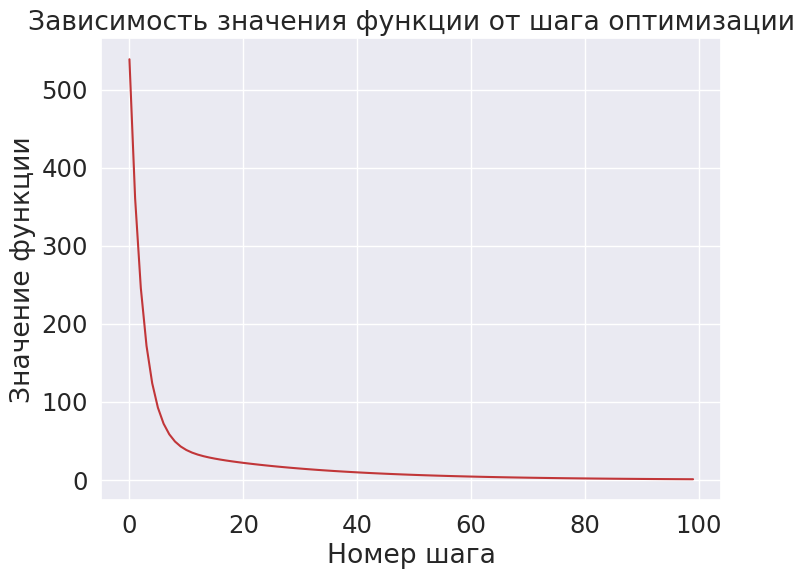

In [11]:
history, losses = optimize(optimizer, func_optimize, x, n_iter=100)

Посмотрим, как оно обучалось.

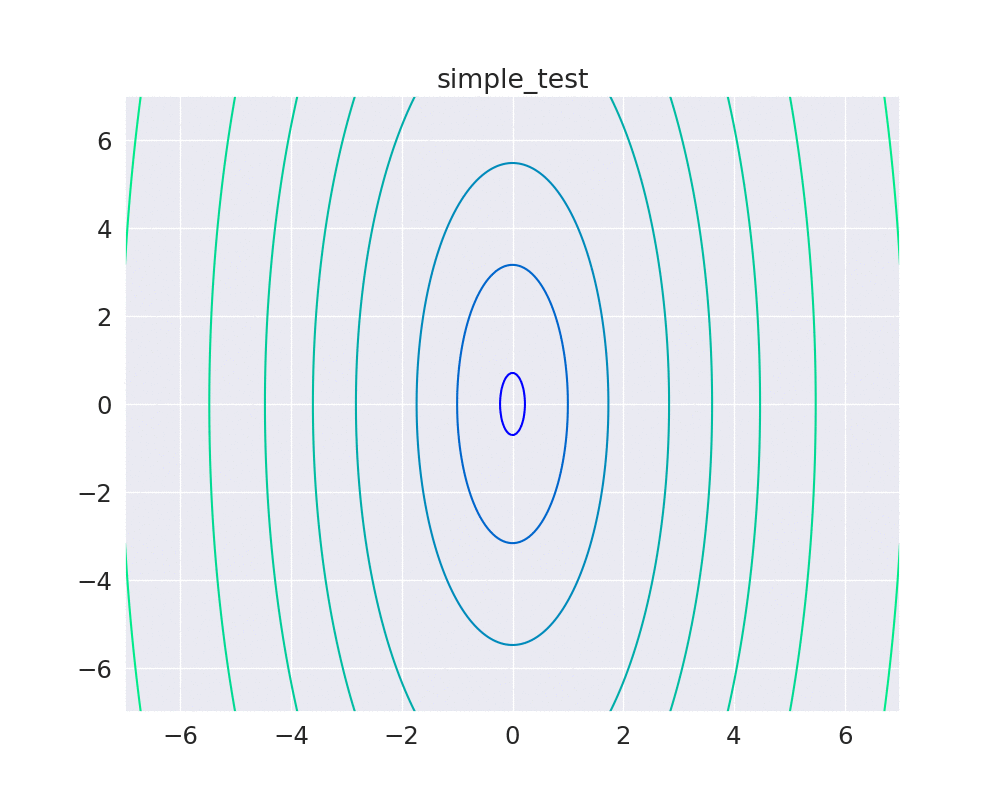

In [12]:
graph_title = 'simple_test'
make_experiment(func_optimize, history, graph_title=graph_title,
                    min_y=-7, max_y=7, min_x=-7, max_x=7)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

Более сложный пример

In [13]:
x_init = torch.tensor([7., -7.])
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.SGD([x], lr=0.01, momentum=0.0)

def func_optimize(x):
    return (x[0]**2+x[1]**2)*(torch.sin(3*x[0])*torch.cos(2*x[1])+x[0]**2/14+x[1]**2/14) - (x[0]+x[1]+x[0]*x[1]/7)**2+80

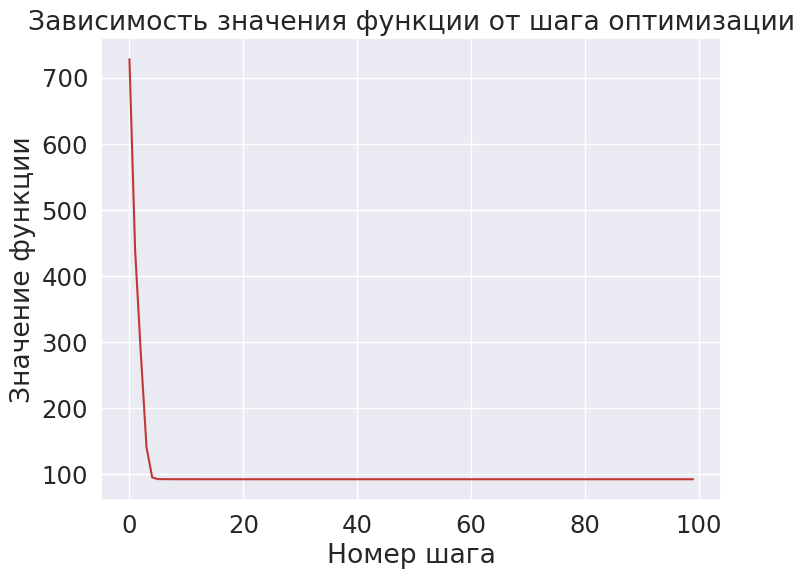

In [14]:
history, losses = optimize(optimizer, func_optimize, x, n_iter=100)

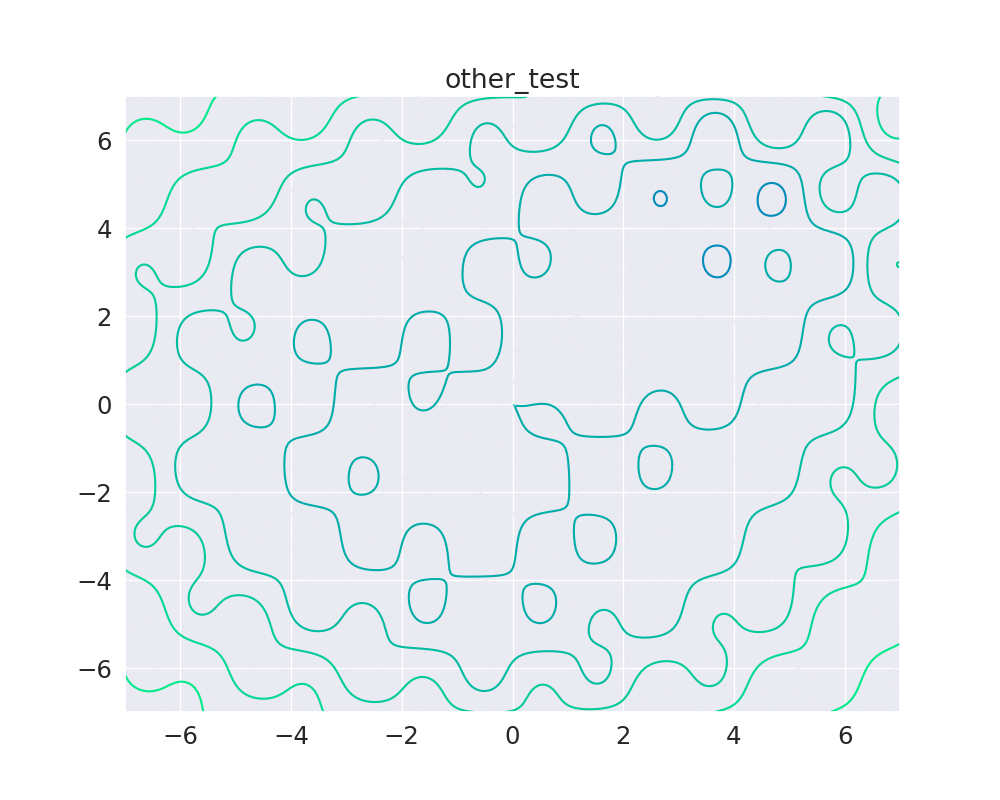

In [15]:
graph_title = 'other_test'
make_experiment(func_optimize, history, graph_title=graph_title,
                    min_y=-7, max_y=7, min_x=-7, max_x=7)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

**Задание 1**

По аналогии с написанным выше проведите эксперименты с остальными оптимизаторами.

**SGD + weight**

Простой пример

In [16]:
x_init = torch.tensor([7., -7.])
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.SGD([x], lr=0.01, momentum=0.9)

def func_optimize(x):
    return 10 * x[0] ** 2 + x[1] **2

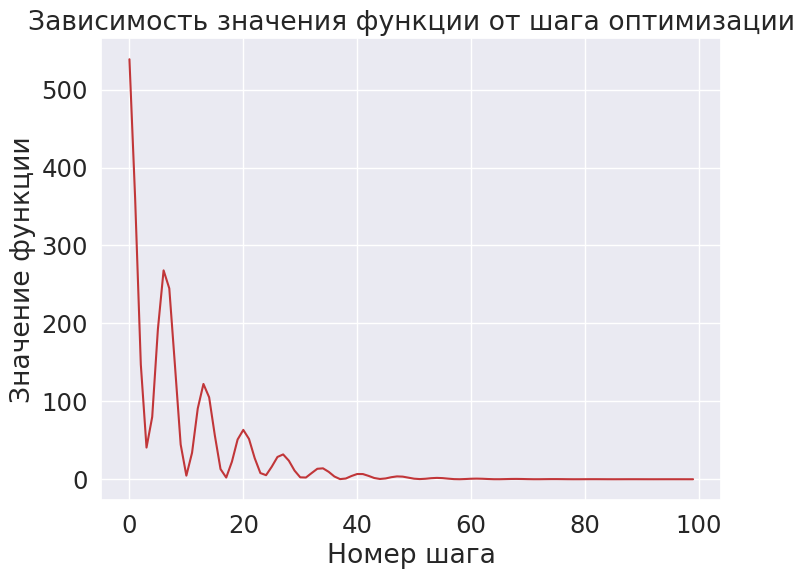

In [17]:
history, losses = optimize(optimizer, func_optimize, x, n_iter=100)

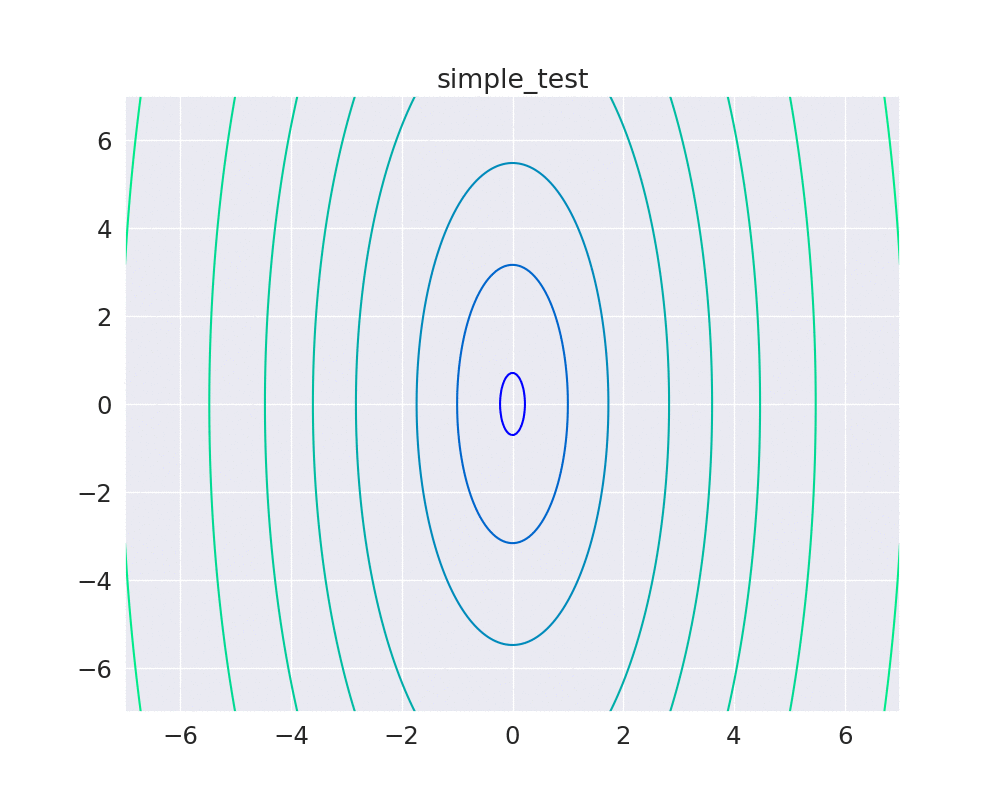

In [18]:
graph_title = 'simple_test'
make_experiment(func_optimize, history, graph_title=graph_title,
                    min_y=-7, max_y=7, min_x=-7, max_x=7)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

Сложный пример

In [19]:
x_init = torch.tensor([7., -7.])
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.SGD([x], lr=0.01, momentum=0.9)

def func_optimize(x):
    return (x[0]**2+x[1]**2)*(torch.sin(3*x[0])*torch.cos(2*x[1])+x[0]**2/14+x[1]**2/14) - (x[0]+x[1]+x[0]*x[1]/7)**2+80

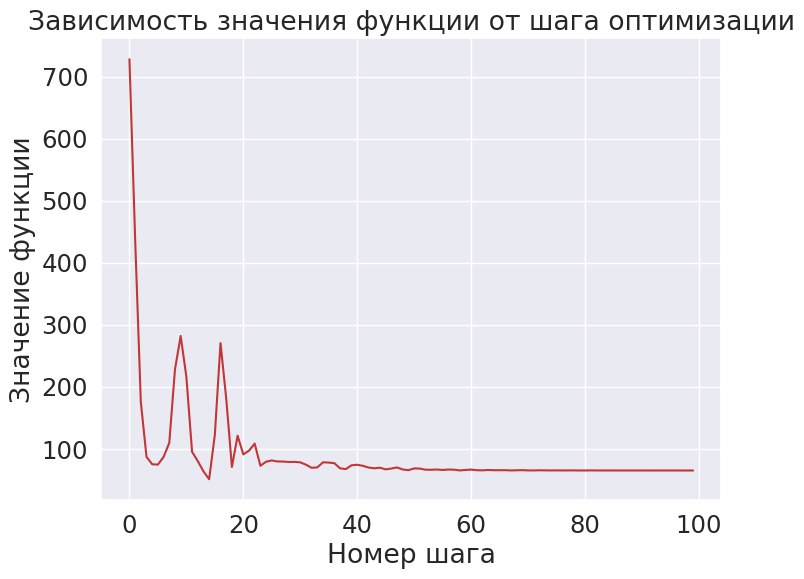

In [20]:
history, losses = optimize(optimizer, func_optimize, x, n_iter=100)

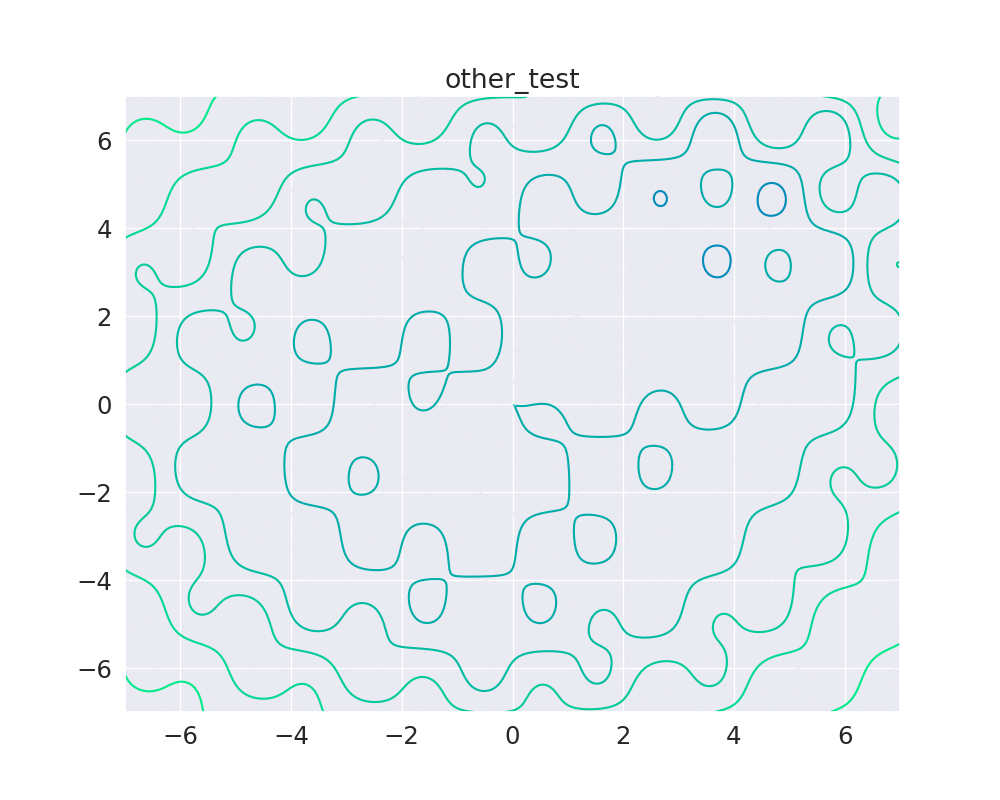

In [21]:
graph_title = 'other_test'
make_experiment(func_optimize, history, graph_title=graph_title,
                    min_y=-7, max_y=7, min_x=-7, max_x=7)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

**Adagrad**

Простой пример

In [70]:
x_init = torch.tensor([7., -7.])
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.Adagrad([x], lr=0.8, eps = 1e-10)

def func_optimize(x):
    return 10 * x[0] ** 2 + x[1] **2

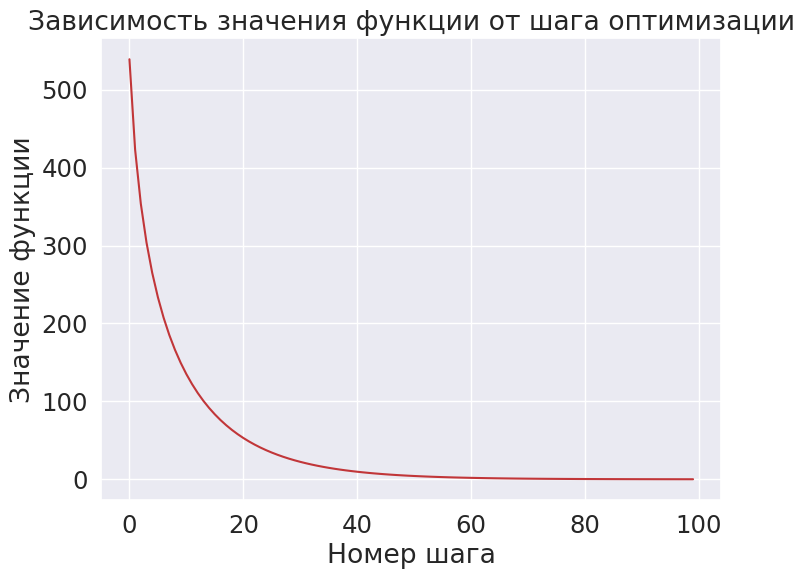

In [71]:
history, losses = optimize(optimizer, func_optimize, x, n_iter=100)

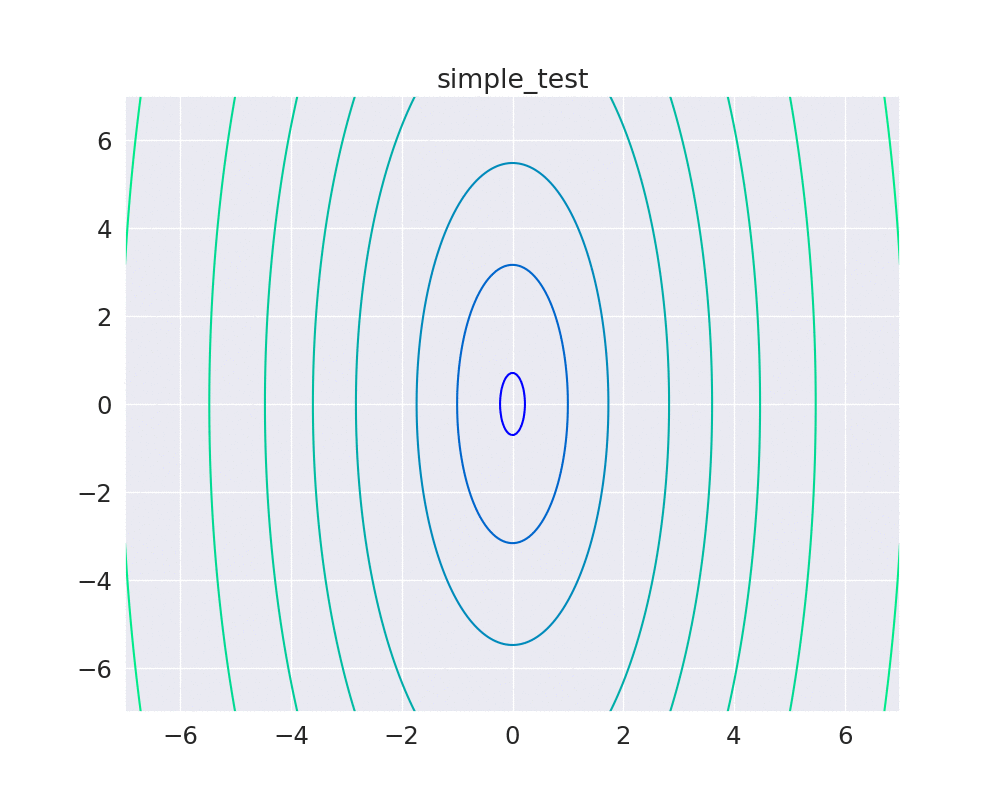

In [72]:
graph_title = 'simple_test'
make_experiment(func_optimize, history, graph_title=graph_title,
                    min_y=-7, max_y=7, min_x=-7, max_x=7)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

Сложный пример

In [73]:
x_init = torch.tensor([7., -7.])
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.Adagrad([x], lr=0.8, eps = 1e-10)

def func_optimize(x):
    return (x[0]**2+x[1]**2)*(torch.sin(3*x[0])*torch.cos(2*x[1])+x[0]**2/14+x[1]**2/14) - (x[0]+x[1]+x[0]*x[1]/7)**2+80

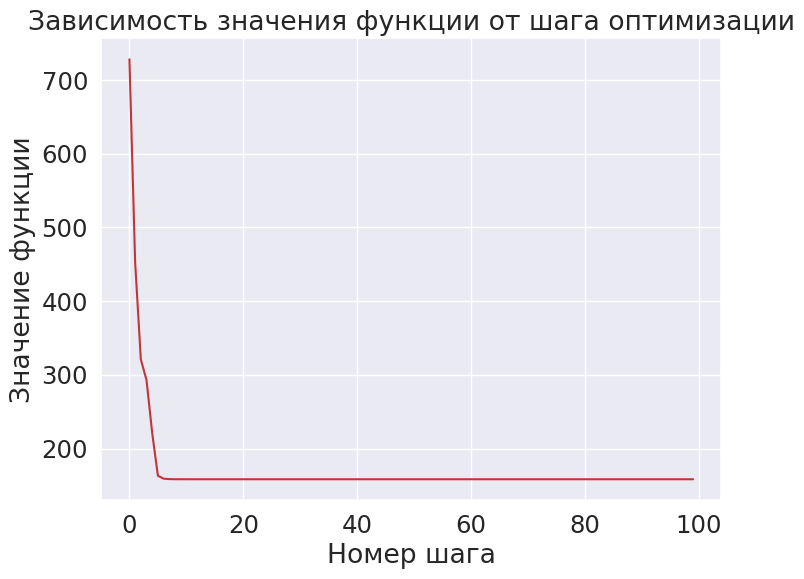

In [74]:
history, losses = optimize(optimizer, func_optimize, x, n_iter=100)

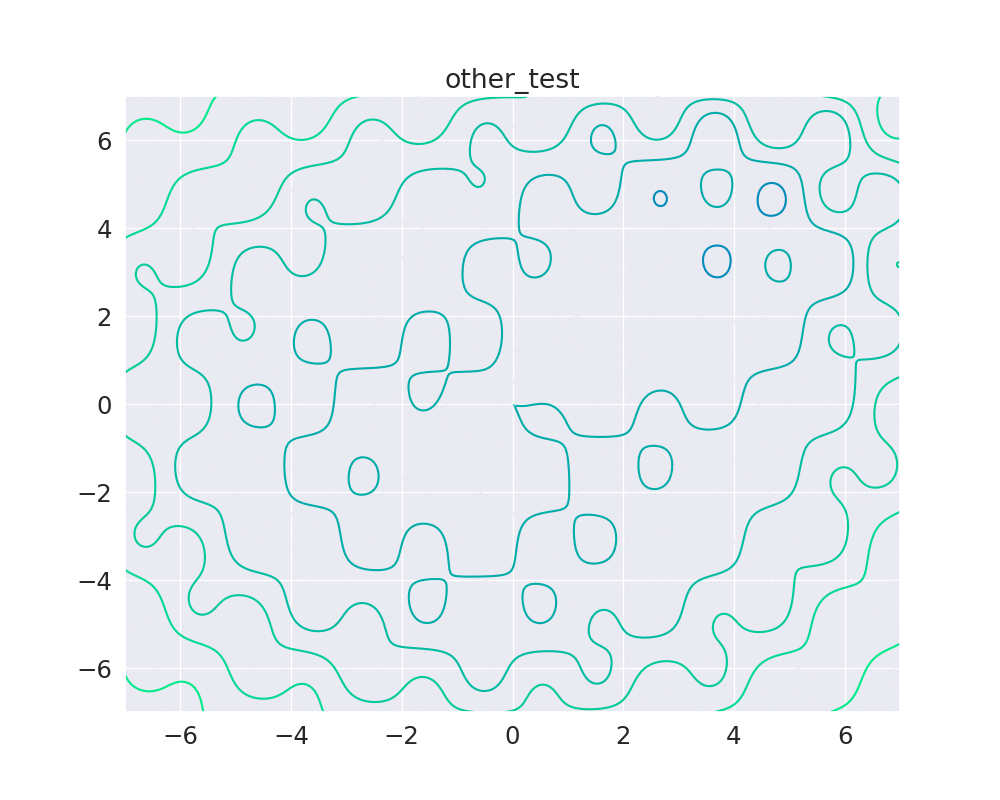

In [75]:
graph_title = 'other_test'
make_experiment(func_optimize, history, graph_title=graph_title,
                    min_y=-7, max_y=7, min_x=-7, max_x=7)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

**RMSProp**

Простой пример

In [52]:
x_init = torch.tensor([7., -7.])
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.RMSprop([x], lr=0.1, alpha = 0.99, eps = 1e-08)

def func_optimize(x):
    return 10 * x[0] ** 2 + x[1] **2

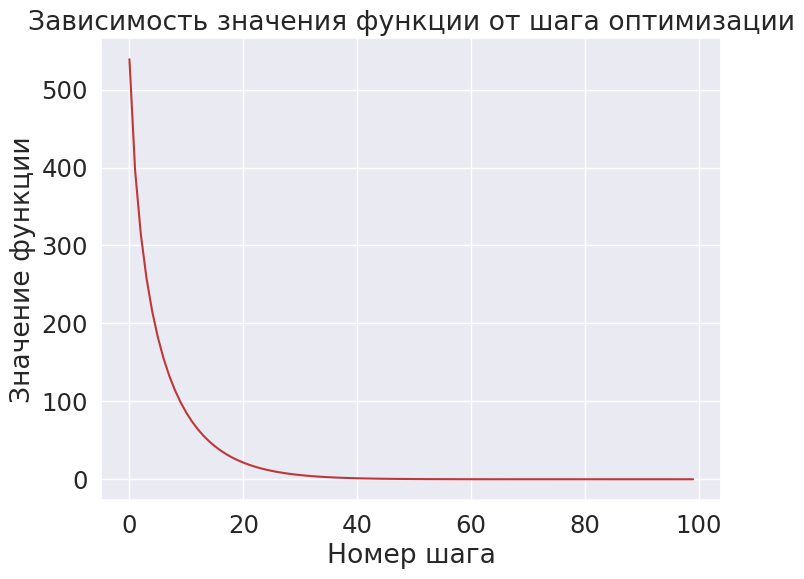

In [53]:
history, losses = optimize(optimizer, func_optimize, x, n_iter=100)

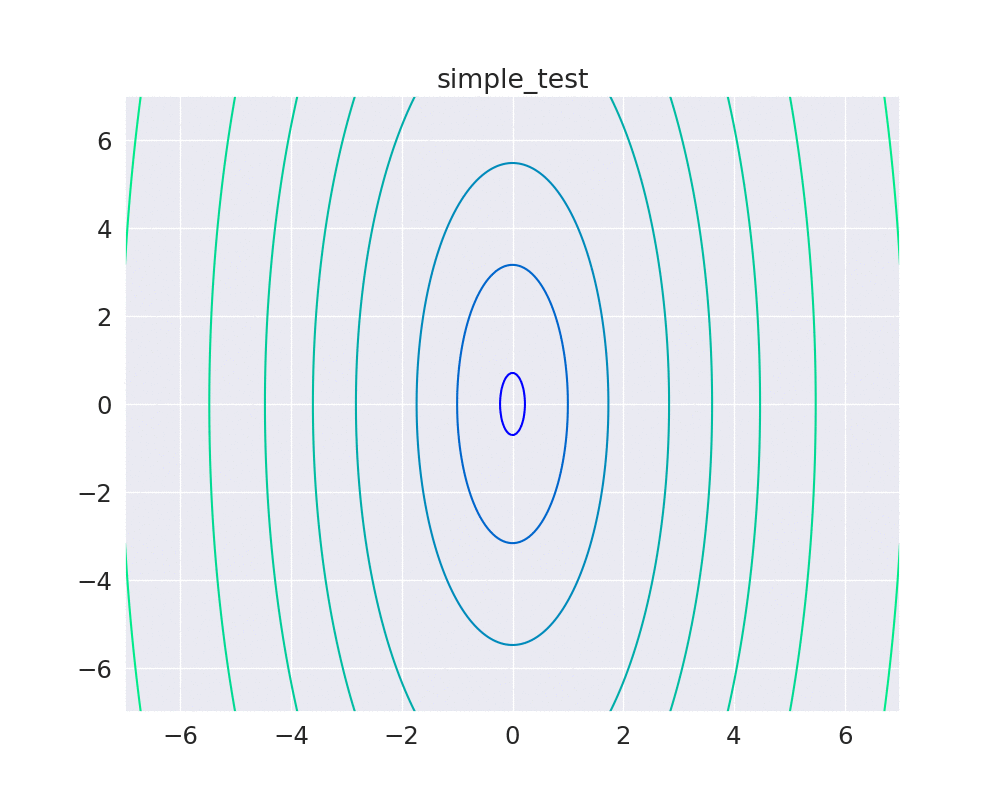

In [54]:
graph_title = 'simple_test'
make_experiment(func_optimize, history, graph_title=graph_title,
                    min_y=-7, max_y=7, min_x=-7, max_x=7)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

Сложный пример

In [55]:
x_init = torch.tensor([7., -7.])
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.RMSprop([x], lr=0.1, alpha = 0.99, eps = 1e-08)

def func_optimize(x):
    return (x[0]**2+x[1]**2)*(torch.sin(3*x[0])*torch.cos(2*x[1])+x[0]**2/14+x[1]**2/14) - (x[0]+x[1]+x[0]*x[1]/7)**2+80

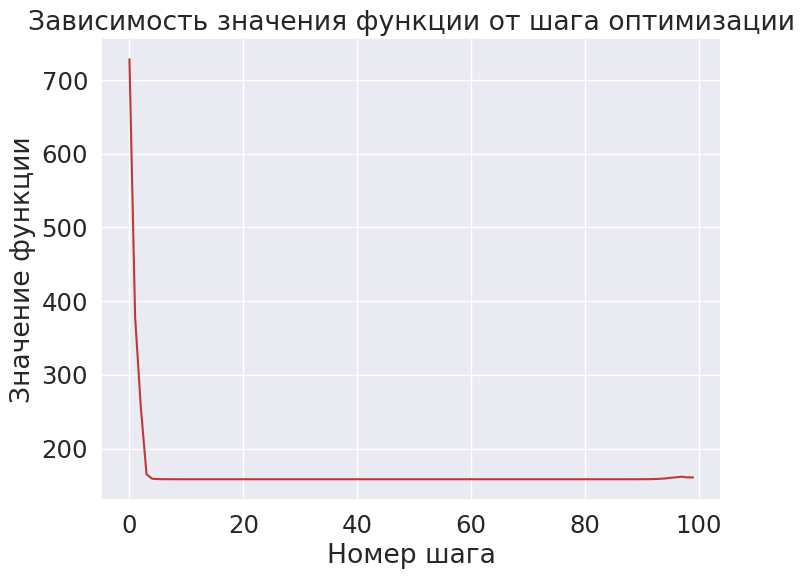

In [56]:
history, losses = optimize(optimizer, func_optimize, x, n_iter=100)

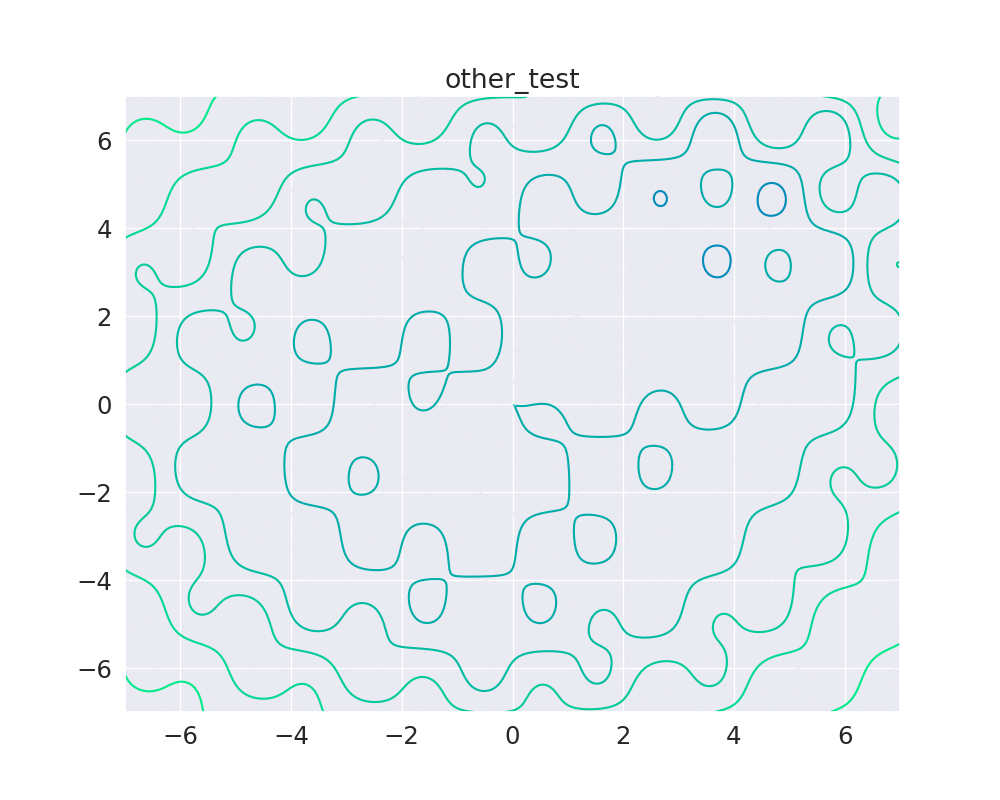

In [57]:
graph_title = 'other_test'
make_experiment(func_optimize, history, graph_title=graph_title,
                    min_y=-7, max_y=7, min_x=-7, max_x=7)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

**Adadelta**

Простой пример

In [58]:
x_init = torch.tensor([7., -7.])
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.Adadelta([x], lr=3.0, rho = 0.9, eps = 1e-06)

def func_optimize(x):
    return 10 * x[0] ** 2 + x[1] **2

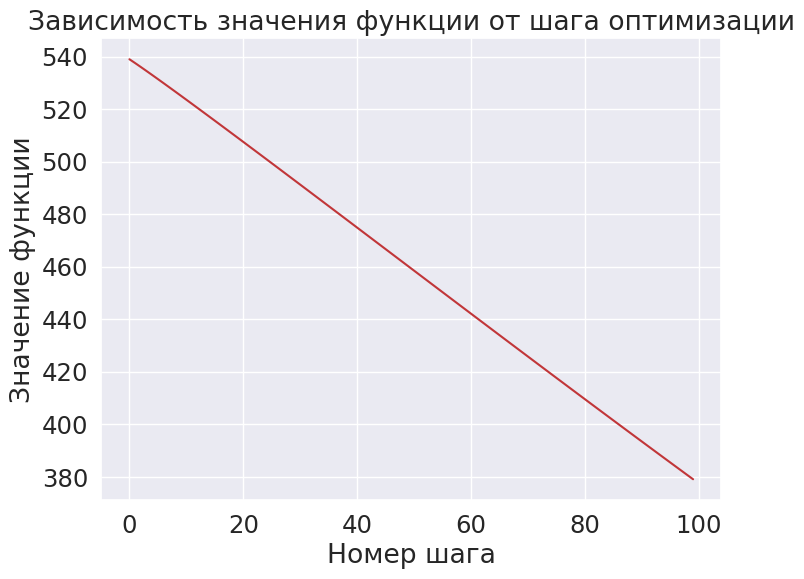

In [59]:
history, losses = optimize(optimizer, func_optimize, x, n_iter=100)

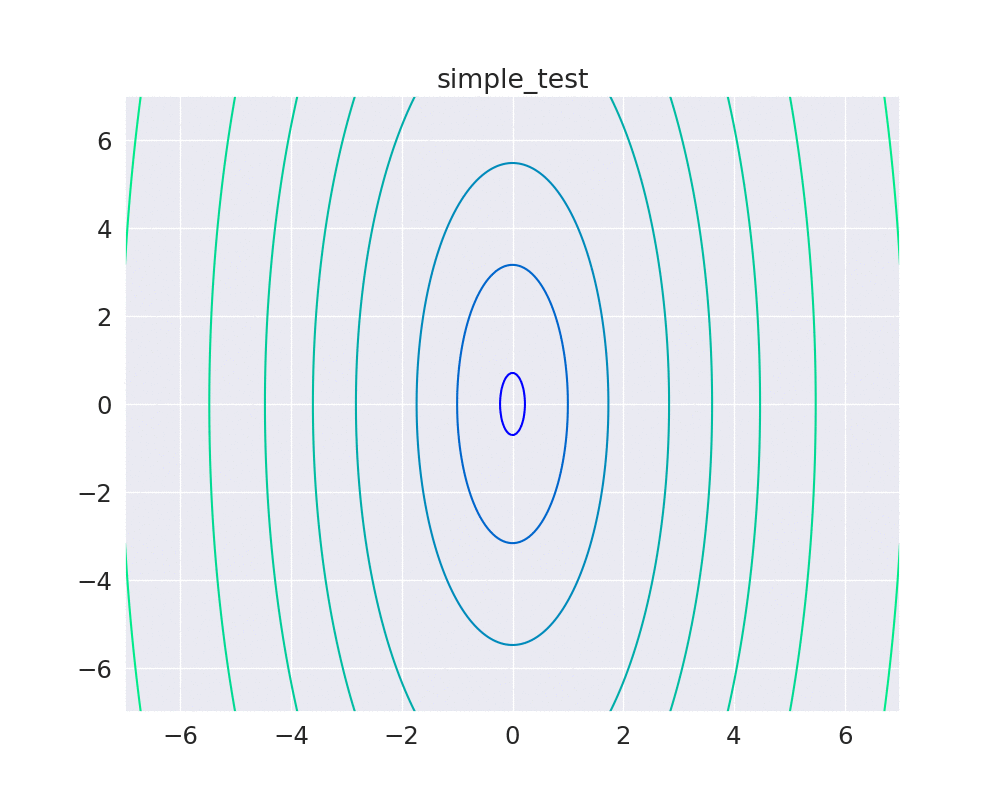

In [60]:
graph_title = 'simple_test'
make_experiment(func_optimize, history, graph_title=graph_title,
                    min_y=-7, max_y=7, min_x=-7, max_x=7)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

Сложный пример

In [61]:
x_init = torch.tensor([7., -7.])
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.Adadelta([x], lr=3.0, rho = 0.9, eps = 1e-06)

def func_optimize(x):
    return (x[0]**2+x[1]**2)*(torch.sin(3*x[0])*torch.cos(2*x[1])+x[0]**2/14+x[1]**2/14) - (x[0]+x[1]+x[0]*x[1]/7)**2+80

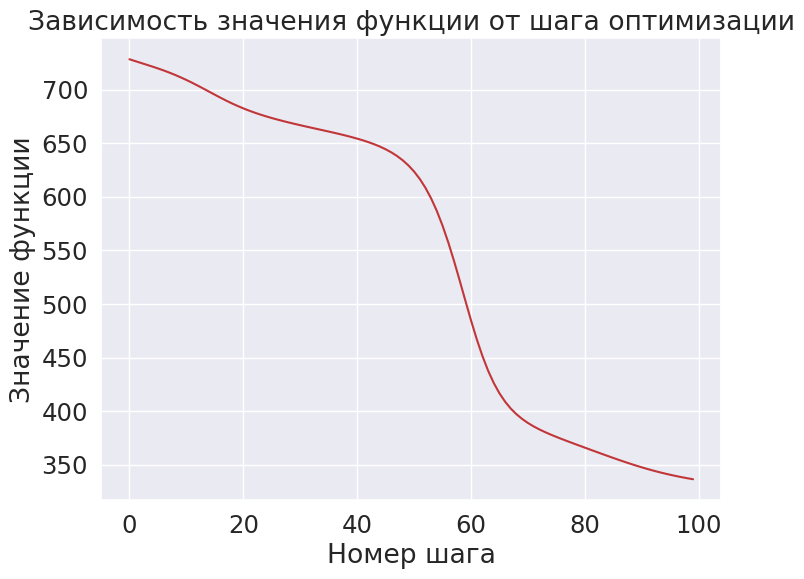

In [62]:
history, losses = optimize(optimizer, func_optimize, x, n_iter=100)

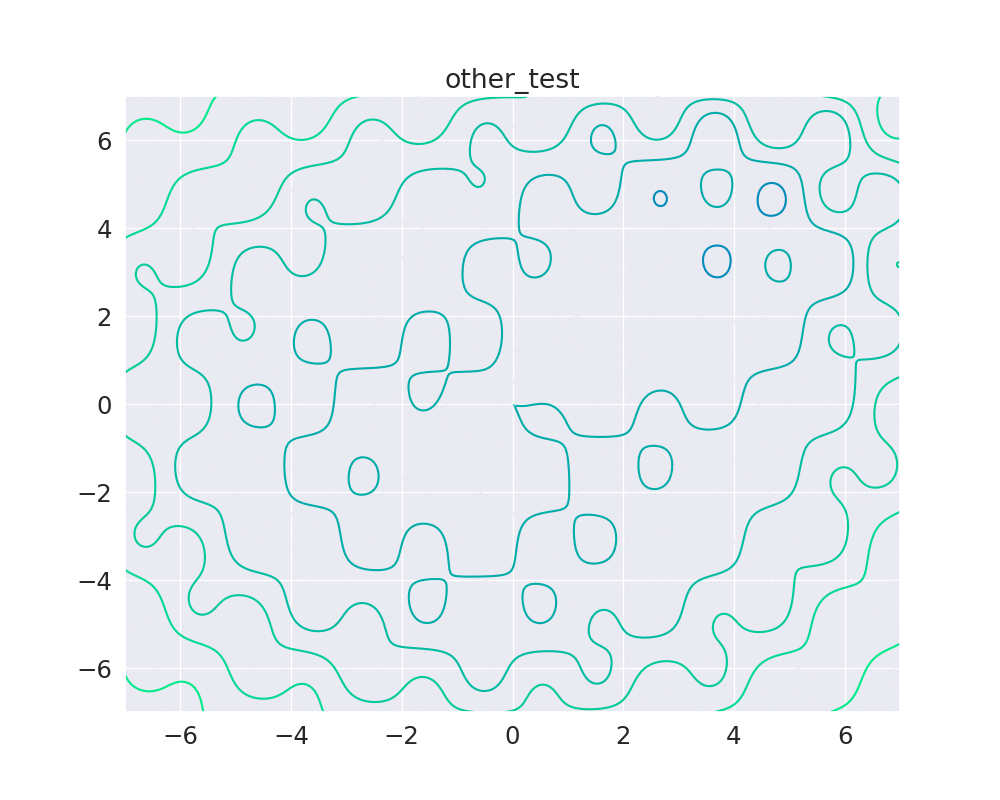

In [63]:
graph_title = 'other_test'
make_experiment(func_optimize, history, graph_title=graph_title,
                    min_y=-7, max_y=7, min_x=-7, max_x=7)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

**Adam**

Простой пример

In [64]:
x_init = torch.tensor([7., -7.])
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.Adam([x], lr=0.1, betas = (0.9, 0.999), eps = 1e-08)

def func_optimize(x):
    return 10 * x[0] ** 2 + x[1] **2

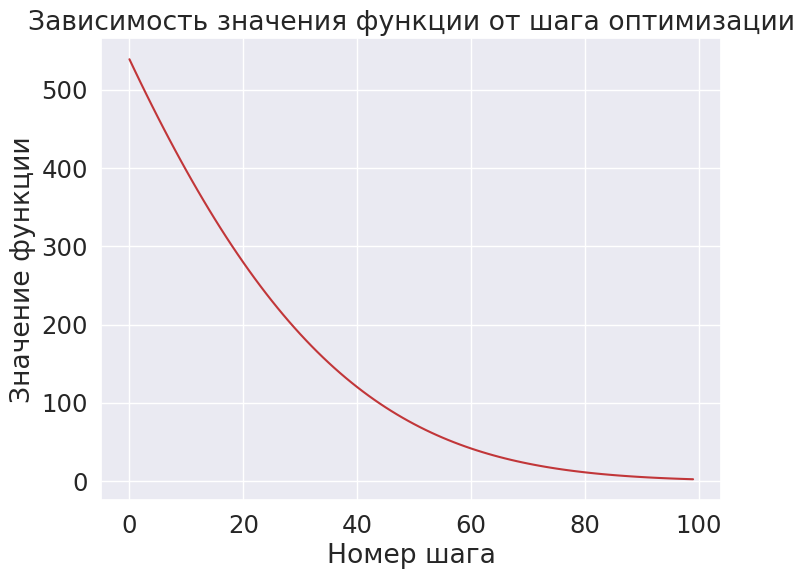

In [65]:
history, losses = optimize(optimizer, func_optimize, x, n_iter=100)

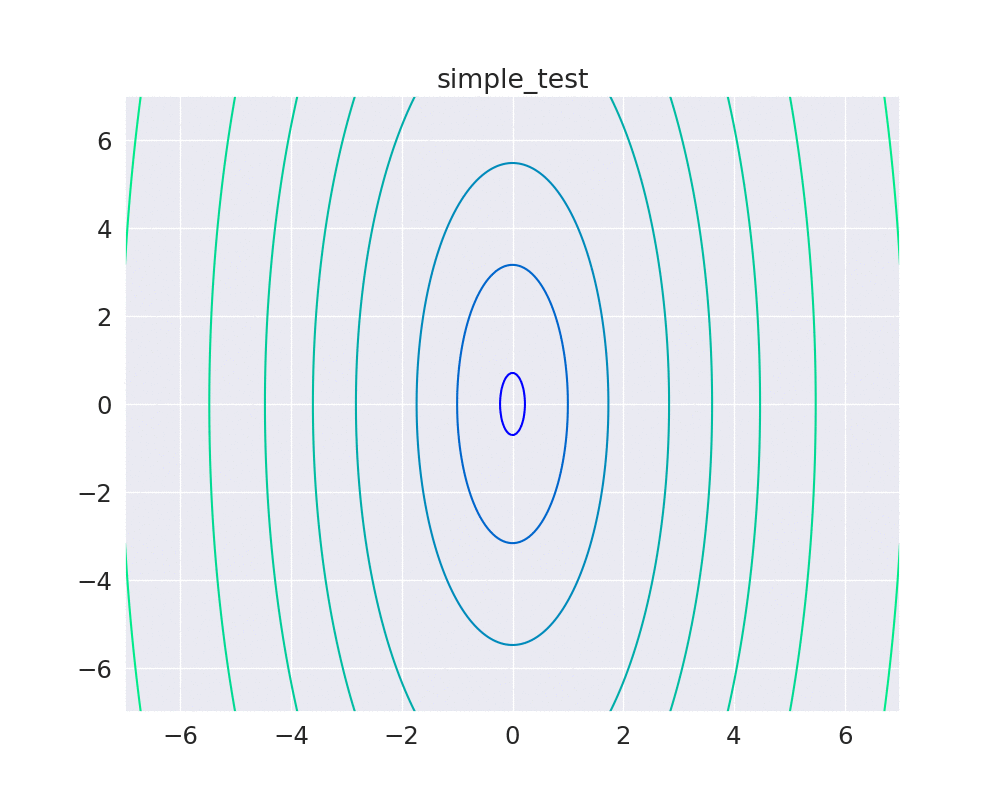

In [66]:
graph_title = 'simple_test'
make_experiment(func_optimize, history, graph_title=graph_title,
                    min_y=-7, max_y=7, min_x=-7, max_x=7)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

Сложный пример

In [67]:
x_init = torch.tensor([7., -7.])
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.Adam([x], lr=0.1, betas = (0.9, 0.999), eps = 1e-08)

def func_optimize(x):
    return (x[0]**2+x[1]**2)*(torch.sin(3*x[0])*torch.cos(2*x[1])+x[0]**2/14+x[1]**2/14) - (x[0]+x[1]+x[0]*x[1]/7)**2+80

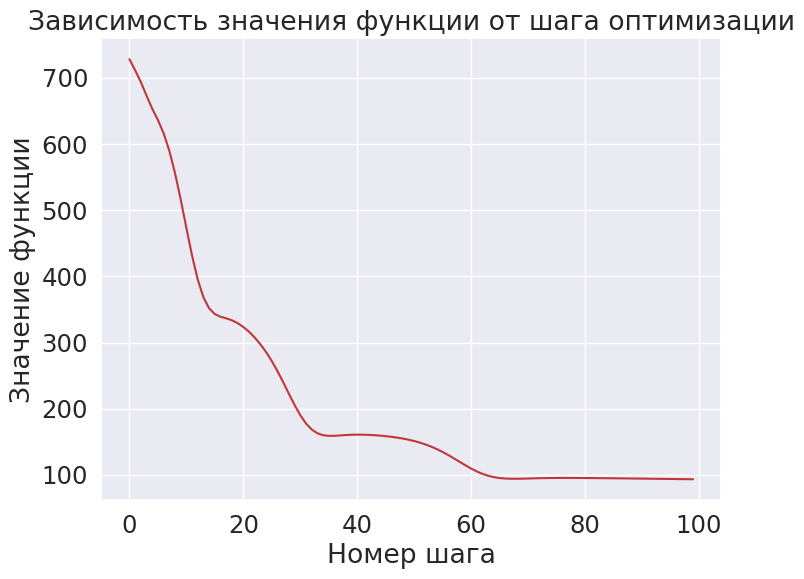

In [68]:
history, losses = optimize(optimizer, func_optimize, x, n_iter=100)

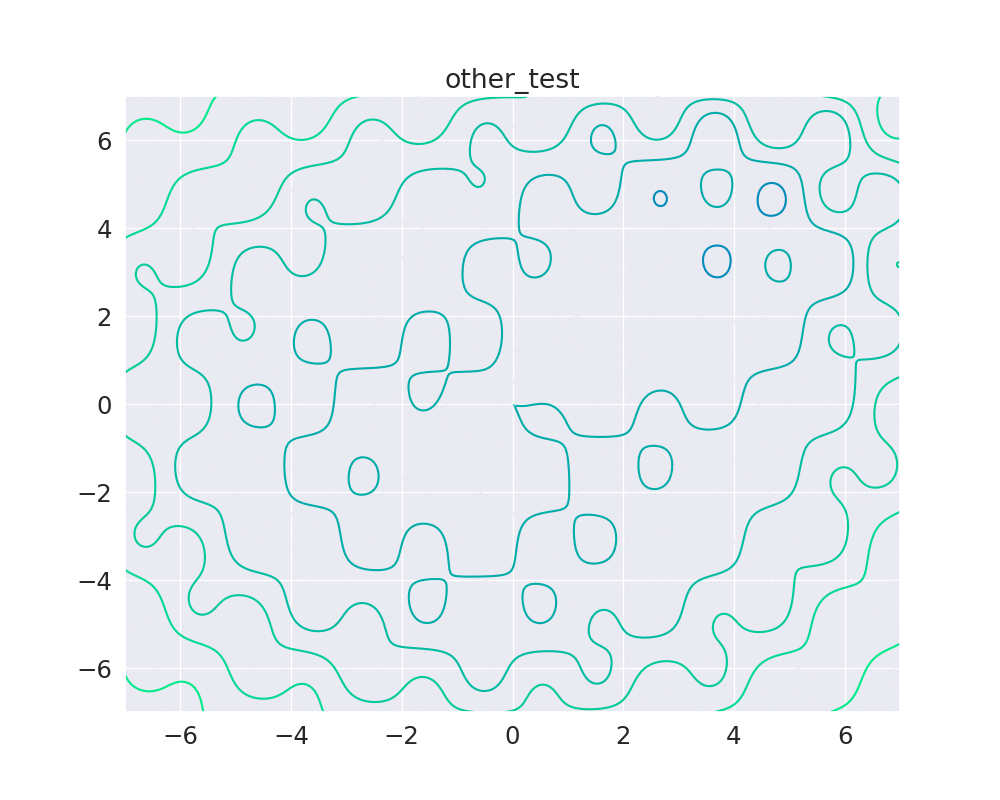

In [69]:
graph_title = 'other_test'
make_experiment(func_optimize, history, graph_title=graph_title,
                    min_y=-7, max_y=7, min_x=-7, max_x=7)
clear_output()
Image(open(f'saved_gifs/{graph_title}.gif','rb').read())

**Выводы:**

Наверное, самое правильное, что можно сказать касательно этого задания: подбор гиперпараметров - это целое искусство. Будь времени побольше, можно бы было подобрать получить результаты лучше.

Также стоит обратить внимание на поведение функций, т.е. как они сходятся к минимумы. Мы можем выидеть и линейные и хаотичные.